In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pynlo
from scipy import constants

In [2]:
def hertzToElectronvolt(pulse):
    """
    Convert the unit of the angular frequency grid corresponding to the pulse
    instance's AW from Hertz to Electronvolt.
    
    Inputs:
    pulse: pulse instance
    
    Outputs:
    W_eV: angular frequency grid corresponding to AW [eV]
    """
    
    W_eV = constants.h * (pulse.W_mks / (2*np.pi)) / constants.e
    
    return W_eV

In [3]:
def spectralPowerDensity(pulse, zW):
    """
    Calculate the spectral power density in unit of watt per electronvolt from
    the intensity data in decibel.
    """
    effective_area = np.pi * fiber_rad**2  # [m^2]
    average_power = pulse.calc_epp() * pulse.frep_mks  # [W]
    intensity_in = average_power / effective_area  # [W / m^2]

    intensity_SI = 10**(zW/10) * intensity_in
    power_per_ev = intensity_SI * effective_area
    
    return power_per_ev

In [4]:
class GasPropertyBuilder:
    
    def __init__(self, fiber_length, fiber_radius, n2_at_one_bar, betas_at_one_bar, pulse_wavelength, 
                 constant_pressure=None, pressure_boundary=None, differential_pumping=False):
        
        assert (constant_pressure is not None) or (pressure_boundary is not None)
        self.fiber_length = fiber_length
        self.fiber_radius = fiber_radius
        
        if differential_pumping:
            self.pressure_entrance = pressure_boundary[0]
            self.pressure_exit = pressure_boundary[1]
        else:
            self.constant_pressure = constant_pressure
        
        self.n2_at_one_bar = n2_at_one_bar
        self.betas_at_one_bar = betas_at_one_bar
        self.pulse_wavelength = pulse_wavelength
        self.differential_pumping = differential_pumping
        
    def torrToBar(self, pressure_Torr):
        """
        Convert the unit of gas pressure from Torr to Bar.
        1 torr is defined as exactly 1/760 of a standard atmosphere (101325 Pa), while
        1 pascal is equal to 1e-5 bar.

        Inputs:
        pressure_Torr: gas pressure [Torr]

        Outputs:
        pressure_Bar: gas pressure [Bar]
        """

        pressure_Pa = pressure_Torr * (101325/760)
        pressure_Bar = pressure_Pa * 1e-5

        return pressure_Bar

    def pressureDistribution(self, z):
        """
        Generate the gas pressure distribution along the fiber under differential pumping scheme.

        Reference: ROBINSON, J. S., et al.
        “The Generation of Intense, Transform-Limited Laser Pulses with Tunable Duration from 6 to 30 Fs in a Differentially Pumped Hollow Fibre.”
        Applied Physics. B, Lasers and Optics, vol. 85, no. 4, 2006, pp. 525–29, https://doi.org/10.1007/s00340-006-2390-z.

        Inputs:
        z: position grid along the fiber [m]
        fiber_length: length of the fiber [m]
        pressure_entrance: pressures at the entrance [Torr]
        pressure_exit: pressures at the exit [Torr]

        Outputs:
        pressure_distribution: gas pressure distribution along the fiber [Bar]
        """
        
        pressure_entrance = self.torrToBar(self.pressure_entrance)
        pressure_exit = self.torrToBar(self.pressure_exit)
        pressure_distribution = np.sqrt(pressure_entrance**2 + (z/self.fiber_length) * (pressure_exit**2 - pressure_entrance**2))
        
        return pressure_distribution
    
    def dispersionFunction(self, z):
        
        pressure_distribution = self.pressureDistribution(z)
        
        betas = []
        for beta in self.betas_at_one_bar:
            betas.append(beta*(1/1e3)*pressure_distribution)
        
        return (betas[0], betas[1], betas[2])
        
    def nonlinearIndexN2(self, pressure):
        """
        Calculate the nonlinear refractive index n2.

        Inputs:
        pressure: pressure of the gas, can be a constant or a function of the length along the fiber [Bar]
        n2_at_one_bar: nonlinear refractive index of the gas quoted at pressure = 1Bar [m^2/(W bar)]

        Outputs:
        n2: nonlinear refractive index n2 at specified pressure [m^2/W]
        """
        
        n2 = pressure * self.n2_at_one_bar
        
        return n2

    def nonlinearParameterGamma(self, n2):
        """
        Calculate the nonlinear parameter Gamma.
        Based on equation from Agrawal's "Nonlinear Fiber Optics": Gamma = (n2*omega0)/(c*A_eff)

        c: speed of light [m/s]
        omega0 = (2*pi*c)/pulseWL: angular frequency [rad/s]
        A_eff: effective core area of the fiber [m^2]

        Inputs:
        n2: nonlinear refractive index at specified pressure, can be a constant if gas pressure
        is constant along the length of the fiber, or an array if gas pressure varies [m^2/W]
        pulseWL: pulse central wavelength [nm]
        fiber_rad: radius of fiber [m]

        Outputs:
        Gamma: nonlinear parameter [1/(W m)]
        """
        
        Gamma = ((2*np.pi) / (self.pulse_wavelength*1e-9)) * (n2 / (np.pi*self.fiber_radius**2))
        
        return Gamma

    def gammaDistribution(self, z=None):
        """
        Calculate the gamma distribution along the fiber.
        """
        
        if self.differential_pumping:
            assert (z is not None)
            pressure_distribution = self.pressureDistribution(z)
            n2 = self.nonlinearIndexN2(pressure_distribution)
            Gamma = self.nonlinearParameterGamma(n2)
            return Gamma
        else:
            constant_pressure = self.torrToBar(self.constant_pressure)
            n2 = self.nonlinearIndexN2(constant_pressure)
            Gamma = self.nonlinearParameterGamma(n2)
            return Gamma


In [5]:
# pulse parameters
FWHM = 0.16         # pulse duration (ps)
pulseWL = 1035      # fundamental pulse central wavelength (nm)
EPP = 2e-6          # Energy per pulse (J)
GDD = 0.0           # Group delay dispersion (ps^2)
TOD = 0.0           # Third order dispersion (ps^3)


# fibre parameters
Length = 100        # length in mm
Alpha = 0.0         # attentuation coefficient (dB/cm)
fiber_rad = 15e-6   # radius (m)
fibWL = pulseWL     # Center WL of fiber (nm)
alpha = np.log((10**(Alpha * 0.1))) * 100  # convert from dB/cm to 1/m


# Xenon gas at 800nm, dispersive coefficients (betas), pressure-dependent nonlinear refractive index (n2)
beta2 = 0.9113                    # (fs^2/cm)
beta3 = 0.7836                    # (fs^3/cm)
n2_Xe_at_one_bar = 1.115e-22      # (m^2/(W bar)), (Arnaud Couairon et al, 2008)


beta2 *= (1e-3)**2/1e-5           # (ps^2/km)
beta3 *= (1e-3)**3/1e-5           # (ps^3/km)
beta4 = 0                         # (ps^4/km) (value not found)


# simulation parameters
Window = 2.5        # simulation window (ps)
Steps = 100         # simulation steps
Points = 2**15      # simulation points
Raman = True        # Enable Raman effect?
Steep = True        # Enable self steepening?


gasbuilder = GasPropertyBuilder(fiber_length=Length*1e-3, fiber_radius=fiber_rad, betas_at_one_bar=[beta2,beta3,beta4], constant_pressure=None, 
                                pressure_boundary=[1000,0], n2_at_one_bar=n2_Xe_at_one_bar, pulse_wavelength=pulseWL, differential_pumping=True)


### Check pressure distribution:

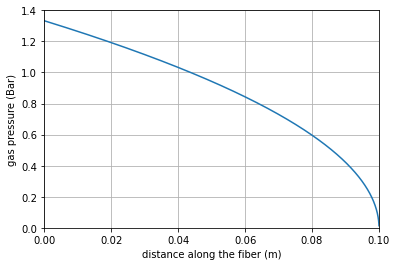

In [6]:
z = np.arange(0, Length, 0.01) * 1e-3  # [m]
pressure = gasbuilder.pressureDistribution(z)
plt.figure()
plt.plot(z, pressure)

plt.xlim(0, 0.1)
plt.ylim(0, 1.4)
plt.xlabel("distance along the fiber (m)")
plt.ylabel("gas pressure (Bar)")
plt.grid()
plt.show()

In [7]:
# create the fiber
fiber1 = pynlo.media.fibers.fiber.FiberInstance()
fiber1.generate_fiber(Length * 1e-3, center_wl_nm=fibWL, betas=gasbuilder.dispersionFunction(0),
                              gamma_W_m=gasbuilder.gammaDistribution(0), gvd_units='ps^n/m', gain=-alpha)

fiber1.set_gamma_function(gasbuilder.gammaDistribution)
fiber1.set_dispersion_function(gasbuilder.dispersionFunction, dispersion_format='GVD')


### Combine the pulses using previous method:

In [8]:
# create the fundamental pulse
pulse_FD = pynlo.light.DerivedPulses.SechPulse(
    4, FWHM/1.76, pulseWL, time_window_ps=Window,
    GDD=GDD, TOD=TOD, NPTS=Points, frep_MHz=1, power_is_avg=True
)
pulse_FD.set_epp(EPP)

# create the second harmonic pulse
pulse_SH = pynlo.light.DerivedPulses.SechPulse(
    3, FWHM/1.76, pulseWL, time_window_ps=Window,
    GDD=GDD, TOD=TOD, NPTS=Points, frep_MHz=1, power_is_avg=True
)
pulse_SH.rotate_spectrum_to_new_center_wl(pulseWL/2)
pulse_SH.set_epp(EPP)

# combine the pulses
pulse = pynlo.light.DerivedPulses.SechPulse(
    7, FWHM/1.76, pulseWL, time_window_ps=Window,
    GDD=GDD, TOD=TOD, NPTS=Points, frep_MHz=1, power_is_avg=True
)
pulse.set_AT(pulse_FD.AT + pulse_SH.AT)

print(f"The fundamental pulse has center wavelength {pulse_FD.center_wavelength_nm} nm and center frequency {pulse_FD.center_frequency_THz} THz.")
print(f"The second harmonic pulse has center wavelength {pulse_SH.center_wavelength_nm} nm and center frequency {pulse_SH.center_frequency_THz} THz.")
print(f"The combined pulse has center wavelength {pulse.center_wavelength_nm} nm and center frequency {pulse.center_frequency_THz} THz.")


The fundamental pulse has center wavelength 1035.0 nm and center frequency 289.65454879227053 THz.
The second harmonic pulse has center wavelength 1035.0 nm and center frequency 289.65454879227053 THz.
The combined pulse has center wavelength 1035.0 nm and center frequency 289.65454879227053 THz.


In [9]:
# propagation
evol = pynlo.interactions.FourWaveMixing.SSFM.SSFM(local_error=0.001, USE_SIMPLE_RAMAN=True,
                 disable_Raman=np.logical_not(Raman),
                 disable_self_steepening=np.logical_not(Steep))

y, AW, AT, pulse_out = evol.propagate(pulse_in=pulse, fiber=fiber1, n_steps=Steps, reload_fiber_each_step=True)


Pulse energy before Simple Fiber : 3999.9999999999914 nJ
pulse energy in  15807856.283093581
copied as   15807856.28309358
Step: 0 Distance remaining: 0.1
Pulse energy after: 3996.878555171193 nJ
Step: 1 Distance remaining: 0.099
Pulse energy after: 3997.2342812316633 nJ
Step: 2 Distance remaining: 0.098
Pulse energy after: 3997.524821964737 nJ
Step: 3 Distance remaining: 0.097
Pulse energy after: 3997.946301014333 nJ
Step: 4 Distance remaining: 0.096
Pulse energy after: 3998.571692651501 nJ
Step: 5 Distance remaining: 0.095
Pulse energy after: 3999.143691696344 nJ
Step: 6 Distance remaining: 0.094
Pulse energy after: 3999.527119774256 nJ
Step: 7 Distance remaining: 0.093
Pulse energy after: 3999.801051128747 nJ
Step: 8 Distance remaining: 0.09200000000000001
Pulse energy after: 3999.9311624131255 nJ
Step: 9 Distance remaining: 0.09100000000000001
Pulse energy after: 3999.832997306787 nJ
Step: 10 Distance remaining: 0.09000000000000001
Pulse energy after: 3999.5795947335246 nJ
Step: 11

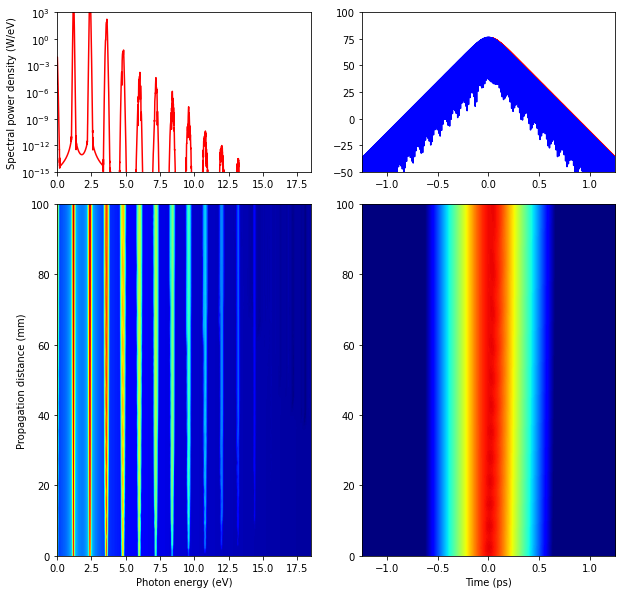

In [10]:
F = (pulse_out.W_mks / (2*np.pi)) * 1e-12 # convert to THz
F_in = (pulse.W_mks / (2*np.pi)) * 1e-12 # convert to THz
# F = pulse.W_THz
W_eV = hertzToElectronvolt(pulse_out)
W_eV_in = hertzToElectronvolt(pulse)

def dB(num):
    return 10 * np.log10(np.abs(num)**2)

zW = dB(np.transpose(AW)[:, (F > 0)])
zT = dB(np.transpose(AT))
zW_input = dB(np.transpose(pulse.AW)[F_in > 0])


power_per_ev = spectralPowerDensity(pulse_out, zW)
power_per_ev_input = spectralPowerDensity(pulse, zW_input)

# set up plots for the results:
fig = plt.figure(figsize=(10,10))
ax0 = plt.subplot2grid((3,2), (0, 0), rowspan=1)
ax1 = plt.subplot2grid((3,2), (0, 1), rowspan=1)
ax2 = plt.subplot2grid((3,2), (1, 0), rowspan=2, sharex=ax0)
ax3 = plt.subplot2grid((3,2), (1, 1), rowspan=2, sharex=ax1)

ax0.set_yscale('log')
ax0.plot(W_eV[W_eV > 0], power_per_ev[-1], color='r')
ax1.plot(pulse.T_ps, zT[-1], color='r')

# ax0.plot(W_eV[W_eV > 0], power_per_ev_input, color='b')
ax1.plot(pulse.T_ps, zT[0], color='b')


extent = (np.min(W_eV[W_eV > 0]), np.max(W_eV[W_eV > 0]), 0, Length)
ax2.imshow(zW, extent=extent, vmin=np.max(zW) - 250.0,
                 vmax=np.max(zW), aspect='auto', origin='lower', cmap='jet')

extent = (np.min(pulse.T_ps), np.max(pulse.T_ps), np.min(y), Length)
ax3.imshow(zT, extent=extent, vmin=np.max(zT) - 60.0,
           vmax=np.max(zT), aspect='auto', origin='lower', cmap='jet')


ax2.set_xlabel('Photon energy (eV)')
ax3.set_xlabel('Time (ps)')

ax0.set_ylabel('Spectral power density (W/eV)')
ax2.set_ylabel('Propagation distance (mm)')

# ax2.set_xlim(0,3)
ax0.set_ylim(1e-15,1e3)
ax0.set_xlim(0,18.5)
ax1.set_ylim(-50,100)

plt.show()

### Combine the pulses (1):

In [11]:
# create the fundamental pulse
pulse_FD = pynlo.light.DerivedPulses.SechPulse(
    4, FWHM/1.76, pulseWL, time_window_ps=Window,
    GDD=GDD, TOD=TOD, NPTS=Points, frep_MHz=1, power_is_avg=True
)
pulse_FD.set_epp(EPP)
W_mks_FD = pulse_FD.W_mks


# create the second harmonic pulse
pulse_SH = pynlo.light.DerivedPulses.SechPulse(
    3, FWHM/1.76, pulseWL, time_window_ps=Window,
    GDD=GDD, TOD=TOD, NPTS=Points, frep_MHz=1, power_is_avg=True
)
pulse_SH.set_epp(EPP)
pulse_SH = pulse_SH.interpolate_to_new_center_wl(pulseWL/2)
W_mks_SH = pulse_SH.W_mks


    
# combine the pulses
pulse = pynlo.light.DerivedPulses.SechPulse(
    7, FWHM/1.76, pulseWL, time_window_ps=Window,
    GDD=GDD, TOD=TOD, NPTS=Points, frep_MHz=1, power_is_avg=True
)
pulse.set_AW(pulse_FD.AW + pulse_SH.AW)
W_mks_TOT = pulse.W_mks


from scipy.interpolate import interp1d
if not np.array_equal(W_mks_FD, W_mks_TOT):
    interpolator = interp1d(pulse_FD.W_mks, pulse_TOT.AW, bounds_error=False, fill_value=0.0)
    AW_TOT_interpolated = interpolator(W_mks_FD)
else:
    AW_TOT_interpolated = pulse.AW
    
pulse.set_AW(AW_TOT_interpolated)


# pulse.rotate_spectrum_to_new_center_wl(776.25)
# pulse.set_epp(2*EPP)

# pulse.set_epp(pulse_FD.calc_epp() + pulse_SH.calc_epp())

# pulse.set_AW(pulse_FD.AW)

# pulse = pynlo.light.PulseBase.Pulse()
# pulse.set_NPTS(Points)
# pulse.set_time_window_ps(Window)
# pulse.set_frep_MHz(1)
# # pulse.set_center_wavelength_nm(pulseWL)
# pulse.set_AW(pulse_FD.AW + pulse_SH.AW)
# # # pulse.set_AT(pulse_FD.AT + pulse_SH.AT)
# pulse.set_center_wavelength_nm(pulse.calculate_weighted_avg_wavelength_nm())
# pulse.set_epp(pulse_FD.calc_epp() + pulse_SH.calc_epp())


print(f"The fundamental pulse has center wavelength {pulse_FD.center_wavelength_nm} nm and center frequency {pulse_FD.center_frequency_THz} THz.")
print(f"The second harmonic pulse has center wavelength {pulse_SH.center_wavelength_nm} nm and center frequency {pulse_SH.center_frequency_THz} THz.")
print(f"The combined pulse has center wavelength {pulse.center_wavelength_nm} nm and center frequency {pulse.center_frequency_THz} THz.")


The fundamental pulse has center wavelength 1035.0 nm and center frequency 289.65454879227053 THz.
The second harmonic pulse has center wavelength 517.5 nm and center frequency 579.3090975845411 THz.
The combined pulse has center wavelength 1035.0 nm and center frequency 289.65454879227053 THz.


In [12]:
print(pulse_SH.calculate_weighted_avg_wavelength_nm())

1034.9973979065335


In [13]:
# propagation
evol = pynlo.interactions.FourWaveMixing.SSFM.SSFM(local_error=0.001, USE_SIMPLE_RAMAN=True,
                 disable_Raman=np.logical_not(Raman),
                 disable_self_steepening=np.logical_not(Steep))

y, AW, AT, pulse_out = evol.propagate(pulse_in=pulse, fiber=fiber1, n_steps=Steps, reload_fiber_each_step=True)


Pulse energy before Simple Fiber : 3990.036596498302 nJ
pulse energy in  15752354.403901722
copied as   15752354.403901722
Step: 0 Distance remaining: 0.1
Pulse energy after: 3986.705727219077 nJ
Step: 1 Distance remaining: 0.099
Pulse energy after: 3986.7501783528537 nJ
Step: 2 Distance remaining: 0.098
Pulse energy after: 3986.809186070961 nJ
Step: 3 Distance remaining: 0.097
Pulse energy after: 3986.884474713539 nJ
Step: 4 Distance remaining: 0.096
Pulse energy after: 3986.970407617066 nJ
Step: 5 Distance remaining: 0.095
Pulse energy after: 3987.051049445648 nJ
Step: 6 Distance remaining: 0.094
Pulse energy after: 3987.119532536578 nJ
Step: 7 Distance remaining: 0.093
Pulse energy after: 3987.1761233178013 nJ
Step: 8 Distance remaining: 0.09200000000000001
Pulse energy after: 3987.213194970175 nJ
Step: 9 Distance remaining: 0.09100000000000001
Pulse energy after: 3987.2248826637815 nJ
Step: 10 Distance remaining: 0.09000000000000001
Pulse energy after: 3987.2205199333057 nJ
Step: 1

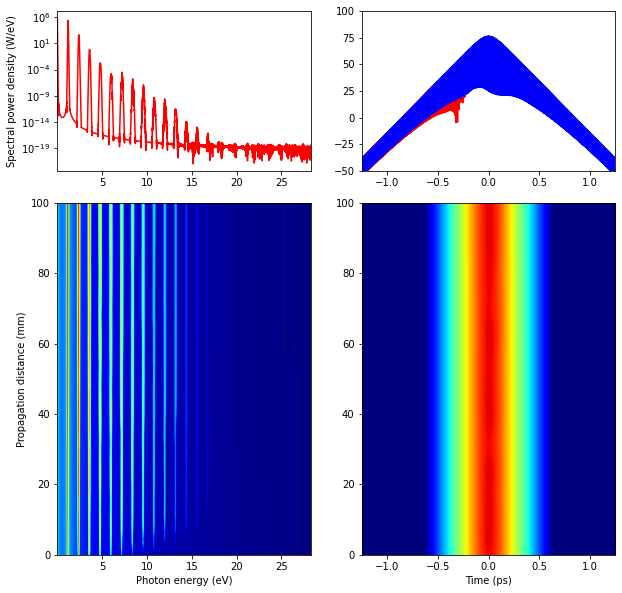

In [14]:
F = (pulse.W_mks / (2*np.pi)) * 1e-12 # convert to THz
# F = pulse.W_THz
W_eV = hertzToElectronvolt(pulse)

def dB(num):
    return 10 * np.log10(np.abs(num)**2)


zW = dB(np.transpose(AW)[:, (F > 0)])
zT = dB(np.transpose(AT))

def spectralPowerDensity(pulse, zW):
    """
    Calculate the spectral power density in unit of watt per electronvolt from
    the intensity data in decibel.
    """
    effective_area = np.pi * fiber_rad**2  # [m^2]
    average_power = pulse.calc_epp() * pulse.frep_mks  # [W]
    intensity_in = average_power / effective_area  # [W / m^2]

    intensity_SI = 10**(zW/10) * intensity_in
    power_per_ev = intensity_SI * effective_area
    
    return power_per_ev


power_per_ev = spectralPowerDensity(pulse_out, zW)

# set up plots for the results:
fig = plt.figure(figsize=(10,10))
ax0 = plt.subplot2grid((3,2), (0, 0), rowspan=1)
ax1 = plt.subplot2grid((3,2), (0, 1), rowspan=1)
ax2 = plt.subplot2grid((3,2), (1, 0), rowspan=2, sharex=ax0)
ax3 = plt.subplot2grid((3,2), (1, 1), rowspan=2, sharex=ax1)

ax0.set_yscale('log')
ax0.plot(W_eV[W_eV > 0], power_per_ev[-1], color='r')
ax1.plot(pulse.T_ps, zT[-1], color='r')

# ax0.plot(W_eV[W_eV > 0], power_per_ev_input, color='b')
ax1.plot(pulse.T_ps, zT[0], color='b')


extent = (np.min(W_eV[W_eV > 0]), np.max(W_eV[W_eV > 0]), 0, Length)
ax2.imshow(zW, extent=extent, vmin=np.max(zW) - 250.0,
                 vmax=np.max(zW), aspect='auto', origin='lower', cmap='jet')

extent = (np.min(pulse.T_ps), np.max(pulse.T_ps), np.min(y), Length)
ax3.imshow(zT, extent=extent, vmin=np.max(zT) - 60.0,
           vmax=np.max(zT), aspect='auto', origin='lower', cmap='jet')


ax2.set_xlabel('Photon energy (eV)')
ax3.set_xlabel('Time (ps)')

ax0.set_ylabel('Spectral power density (W/eV)')
ax2.set_ylabel('Propagation distance (mm)')

# ax2.set_xlim(0,3)
# ax0.set_ylim(1e-15,1e4)
ax1.set_ylim(-50,100)

plt.show()

### Combine the pulses (2):

In [15]:
# create the fundamental pulse
pulse_FD = pynlo.light.DerivedPulses.SechPulse(
    4, FWHM/1.76, pulseWL, time_window_ps=Window,
    GDD=GDD, TOD=TOD, NPTS=Points, frep_MHz=1, power_is_avg=True
)
# pulse_FD.rotate_spectrum_to_new_center_wl(pulseWL)
pulse_FD.set_epp(EPP)

# create the second harmonic pulse
pulse_SH = pynlo.light.DerivedPulses.SechPulse(
    3, FWHM/1.76, pulseWL, time_window_ps=Window,
    GDD=GDD, TOD=TOD, NPTS=Points, frep_MHz=1, power_is_avg=True
)
# pulse_SH.rotate_spectrum_to_new_center_wl(pulseWL/2)

pulse_SH = pulse_SH.interpolate_to_new_center_wl(pulseWL/2)
pulse_SH.set_epp(EPP)
# pulse_SH.set_AT(pulse_SH.AT * np.sqrt( 4 / ( 1*1.0e6 * pulse_SH.calc_epp()) ))

# combine the pulses
pulse = pynlo.light.DerivedPulses.SechPulse(
    7, FWHM/1.76, 776.25, time_window_ps=Window,
    GDD=GDD, TOD=TOD, NPTS=Points, frep_MHz=1, power_is_avg=True
)
pulse.set_AW(pulse_FD.AW + pulse_SH.AW)
# pulse.rotate_spectrum_to_new_center_wl(776.25)
# pulse.set_epp(2*EPP)

pulse.set_epp(pulse_FD.calc_epp() + pulse_SH.calc_epp())

# pulse.set_AW(pulse_FD.AW)

pulse = pynlo.light.PulseBase.Pulse()
pulse.set_NPTS(Points)
pulse.set_time_window_ps(Window)
pulse.set_frep_MHz(1)
# pulse.set_center_wavelength_nm(pulseWL)
pulse.set_AW(pulse_FD.AW + pulse_SH.AW)
# # pulse.set_AT(pulse_FD.AT + pulse_SH.AT)
pulse.set_center_wavelength_nm(pulse.calculate_weighted_avg_wavelength_nm())
pulse.set_epp(pulse_FD.calc_epp() + pulse_SH.calc_epp())


In [16]:
# propagation
evol = pynlo.interactions.FourWaveMixing.SSFM.SSFM(local_error=0.001, USE_SIMPLE_RAMAN=True,
                 disable_Raman=np.logical_not(Raman),
                 disable_self_steepening=np.logical_not(Steep))

y, AW, AT, pulse_out = evol.propagate(pulse_in=pulse, fiber=fiber1, n_steps=Steps, reload_fiber_each_step=True)


Pulse energy before Simple Fiber : 4000.0000000000014 nJ
pulse energy in  15771690.979392933
copied as   15771690.979392933
Step: 0 Distance remaining: 0.1
Pulse energy after: 3996.591807397895 nJ
Step: 1 Distance remaining: 0.099
Pulse energy after: 3996.7343087904314 nJ
Step: 2 Distance remaining: 0.098
Pulse energy after: 3997.3047247986888 nJ
Step: 3 Distance remaining: 0.097
Pulse energy after: 3997.9071784371263 nJ
Step: 4 Distance remaining: 0.096
Pulse energy after: 3998.284921481507 nJ
Step: 5 Distance remaining: 0.095
Pulse energy after: 3998.6884331092165 nJ
Step: 6 Distance remaining: 0.094
Pulse energy after: 3999.240669256921 nJ
Step: 7 Distance remaining: 0.093
Pulse energy after: 3999.6908098761355 nJ
Step: 8 Distance remaining: 0.09200000000000001
Pulse energy after: 3999.9203709968792 nJ
Step: 9 Distance remaining: 0.09100000000000001
Pulse energy after: 4000.066874958294 nJ
Step: 10 Distance remaining: 0.09000000000000001
Pulse energy after: 4000.1441592831975 nJ
Ste

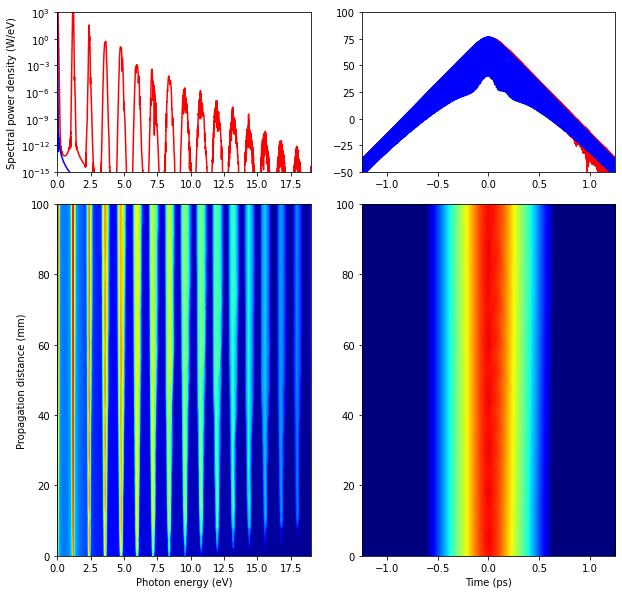

In [17]:
F = (pulse_FD.W_mks / (2*np.pi)) * 1e-12 # convert to THz
# F = pulse.W_THz
W_eV = hertzToElectronvolt(pulse_FD)


def dB(num):
    return 10 * np.log10(np.abs(num)**2)


zW = dB(np.transpose(AW)[:, (F > 0)])
zT = dB(np.transpose(AT))

zW_in = dB(np.transpose(pulse_SH.AW)[F > 0])


def spectralPowerDensity(pulse, zW):
    """
    Calculate the spectral power density in unit of watt per electronvolt from
    the intensity data in decibel.
    """
    effective_area = np.pi * fiber_rad**2  # [m^2]
    average_power = pulse.calc_epp() * pulse.frep_mks  # [W]
    intensity_in = average_power / effective_area  # [W / m^2]

    intensity_SI = 10**(zW/10) * intensity_in
    power_per_ev = intensity_SI * effective_area
    
    return power_per_ev


power_per_ev = spectralPowerDensity(pulse_out, zW)
power_per_ev_in = spectralPowerDensity(pulse_SH, zW_in)

# set up plots for the results:
fig = plt.figure(figsize=(10,10))
ax0 = plt.subplot2grid((3,2), (0, 0), rowspan=1)
ax1 = plt.subplot2grid((3,2), (0, 1), rowspan=1)
ax2 = plt.subplot2grid((3,2), (1, 0), rowspan=2, sharex=ax0)
ax3 = plt.subplot2grid((3,2), (1, 1), rowspan=2, sharex=ax1)

ax0.set_yscale('log')
ax0.plot(W_eV[W_eV > 0], power_per_ev[-1], color='r')
ax1.plot(pulse.T_ps, zT[-1], color='r')

ax0.plot(W_eV[W_eV > 0], power_per_ev_in, color='b')
ax1.plot(pulse.T_ps, zT[0], color='b')


extent = (np.min(W_eV[W_eV > 0]), np.max(W_eV[W_eV > 0]), 0, Length)
ax2.imshow(zW, extent=extent, vmin=np.max(zW) - 250.0,
                 vmax=np.max(zW), aspect='auto', origin='lower', cmap='jet')

extent = (np.min(pulse.T_ps), np.max(pulse.T_ps), np.min(y), Length)
ax3.imshow(zT, extent=extent, vmin=np.max(zT) - 60.0,
           vmax=np.max(zT), aspect='auto', origin='lower', cmap='jet')


ax2.set_xlabel('Photon energy (eV)')
ax3.set_xlabel('Time (ps)')

ax0.set_ylabel('Spectral power density (W/eV)')
ax2.set_ylabel('Propagation distance (mm)')

# ax2.set_xlim(0,3)
ax0.set_ylim(1e-15,1e3)
ax0.set_xlim(0,19)
ax1.set_ylim(-50,100)

plt.show()

When the following grid is used:

`F = (pulse_FD.W_mks / (2*np.pi)) * 1e-12
W_eV = hertzToElectronvolt(pulse_FD)`

The plotted second harmonic field amplitude is on the left of the fundamental field amplitude.

When the grid is set up using the input combined pulse's grid, the resulting pattern is shifted to the lower photon energy and does not match the harmonic generation photon energies.

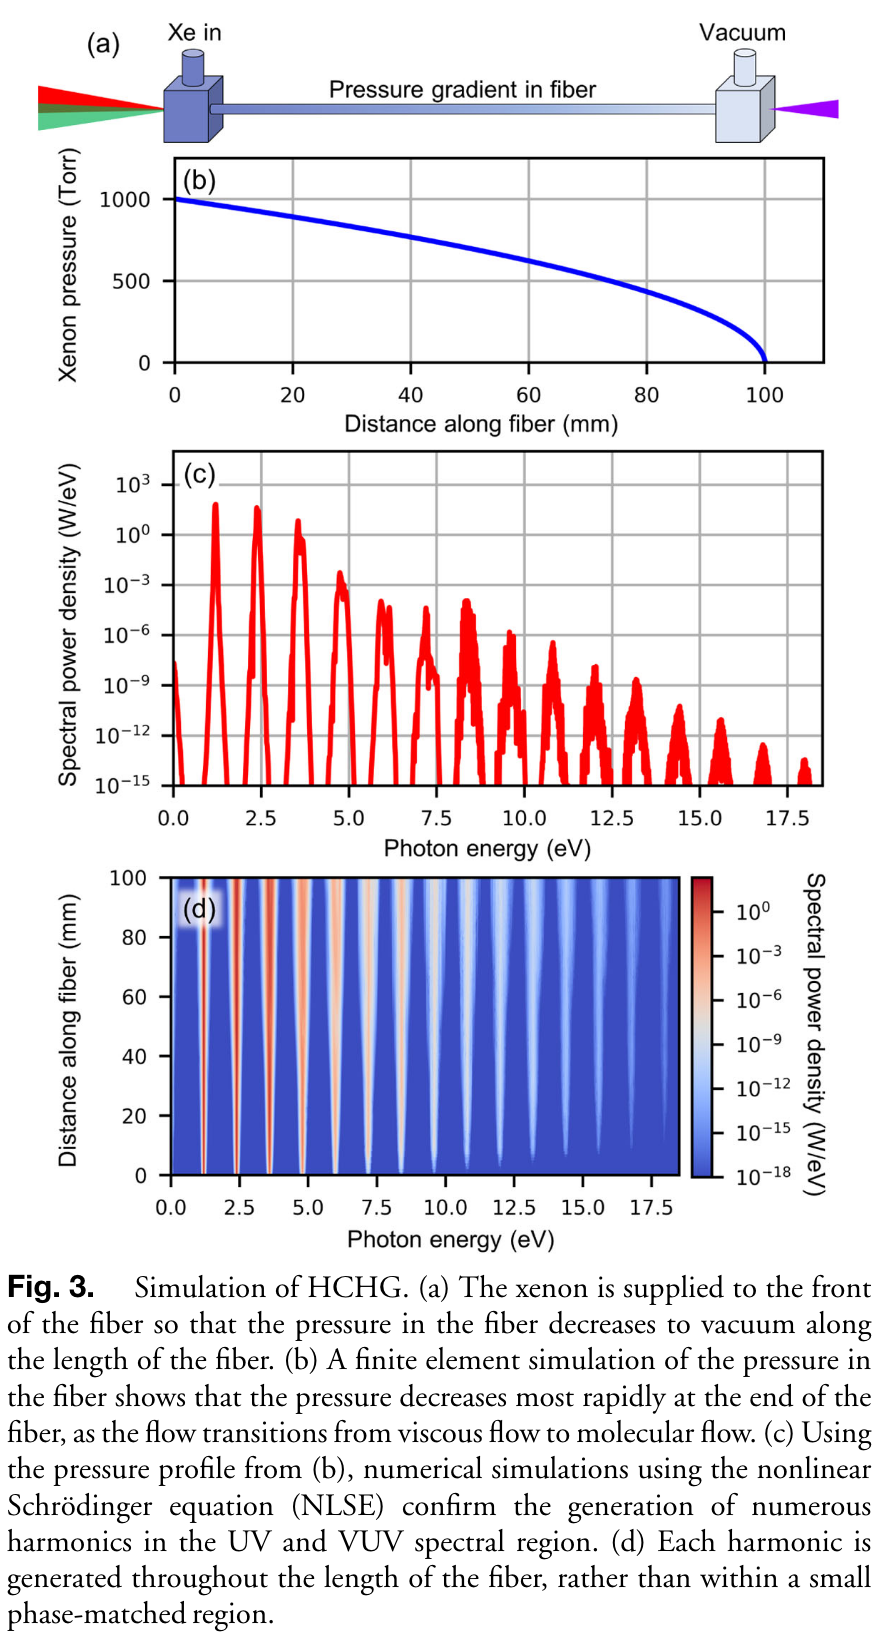